# Preguntas

- Cual es el numero de tarea? The doc says proyecto 1

Proyecto 1 - Luis Eduardo Robles Jimenez

# Minería de Texto para Turismo

## Utils

In [138]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer

In [139]:
class TouristSpot:
    def __init__(self, path):
        self.reviews = pd.read_csv(path)
        self.spotName = path.split('/')[-1][: -4]
        self._cleanUp()
        self.nDashes = 30

    def _cleanUp(self):
        self.reviews.columns = [c.strip() for c in self.reviews.columns]

        if self.reviews.loc[:, 'Edad'].dtypes == object: self.reviews.loc[:, 'Edad'] = [n.strip() for n in self.reviews.loc[:, 'Edad']]
        self.reviews.loc[:, 'Edad'] = self.reviews.loc[:, 'Edad'].replace([np.nan, ''], -1)
        self.reviews.loc[:, 'Edad'] = self.reviews.loc[:, 'Edad'].astype('int32')

        columns = ["Título de la opinión", "Opinión"]
        for col in columns:
            desc = []
            for o in self.reviews.loc[:, col]:
                if o[0] == '"': o = o[1:]
                if o[-1] == '"': o = o[:-1]
                desc.append(o)
            self.reviews.loc[:, col] = desc

    def wordCloud(self):
        #pip install wordcloud
        pass

    def temporalAnalysis(self):

        self.reviews['newDate'] = ['/'.join(date.split('/')[1:]) for date in self.reviews.loc[:, 'Fecha']]

        dates = []
        bad, neutral, good, total = [], [], [], []
        for groupName, reviewsGroup in self.reviews.groupby('newDate'):
            dates.append(groupName)
            bad.append(np.sum(reviewsGroup.loc[:, 'Escala'] < 3))
            neutral.append(np.sum(reviewsGroup.loc[:, 'Escala'] == 3))
            good.append(np.sum(reviewsGroup.loc[:, 'Escala'] > 3))

        grades = np.array(bad) + np.array(neutral) + np.array(good)
        bad =       np.array(bad)       / grades * 100
        neutral =   np.array(neutral)   / grades * 100
        good =      np.array(good)      / grades * 100

        argsort = np.argsort([datetime.strptime(date, '%m/%y' if len(date) == 5 else '%m/%Y') for date in dates])[::-1]
        dates =     np.array([dates[i] for i in argsort])
        bad =       np.array([bad[i] for i in argsort])
        neutral =   np.array([neutral[i] for i in argsort])
        good =      np.array([good[i] for i in argsort])


        _, stackedChart = plt.subplots(figsize = (15, 15))
        stackedChart.barh(dates, good, label='Good reviews', color = '#00ff00')
        stackedChart.barh(dates, neutral, left = good, label='Neutral reviews', color = '#ffff00')
        stackedChart.barh(dates, bad, left = good + neutral, label='Bad reviews', color = '#ff0000')
        stackedChart.legend()
        stackedChart.set_title('100% Stacked Chart')
        plt.show()

    def describe(self):
        nRows, nCols = 2, 1
        fig = plt.figure(figsize = (15, 10))
        fig.subplots_adjust(hspace = 0.5)

        print(self.nDashes * '-', self.spotName, self.nDashes * '-')

        grades = fig.add_subplot(321)
        avg = np.round(np.average(self.reviews.loc[:, 'Escala']), decimals = 2)
        sd = np.round(np.std(self.reviews.loc[:, 'Escala']), decimals = 2)
        grades.hist(self.reviews.loc[:, 'Escala'])
        grades.set_title(f"Grades (1 worst; 5 best); Average = {avg}; SD = {sd}")

        length = fig.add_subplot(322)
        lenOpinions = [len(TweetTokenizer().tokenize(o)) for o in self.reviews.loc[:, 'Opinión']]
        avg = np.round(np.average(lenOpinions), decimals = 2)
        sd = np.round(np.std(lenOpinions), decimals = 2)
        length.hist(lenOpinions)
        length.set_title(f"Length of opinions (words); Average = {avg}; SD = {sd}")

        ages = fig.add_subplot(323)
        ages.hist(self.reviews.loc[:, 'Edad'], bins = 10)
        ages.set_title(f'Ages distribution')

        visitors = fig.add_subplot(324)
        visitors.hist(self.reviews.loc[:, 'Nacional ó Internacional'])
        visitors.set_title('Local or foreigner')

        monthNames = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        popularity = fig.add_subplot(325)
        months = [int(d.split('/')[1]) for d in self.reviews.loc[:, 'Fecha']]
        m, c = np.unique(months, return_counts = True)
        popularity.bar(m, c)
        popularity.set_title('Popularity by month')
        popularity.set_xticks(np.arange(1, len(m) + 1), labels = monthNames)

        languages = fig.add_subplot(326)
        m, c = np.unique(self.reviews.loc[:, 'Idioma'], return_counts = True)
        languages.barh(m, c)
        languages.set_title('Language')

        plt.show()

## Actividades

### 1. Preprocesamiento y stats

In [140]:
path = "../../data/guanajuato/"
spots = [TouristSpot(os.path.join(path, d)) for d in os.listdir(path)]

------------------------------ Teatro Juárez ------------------------------


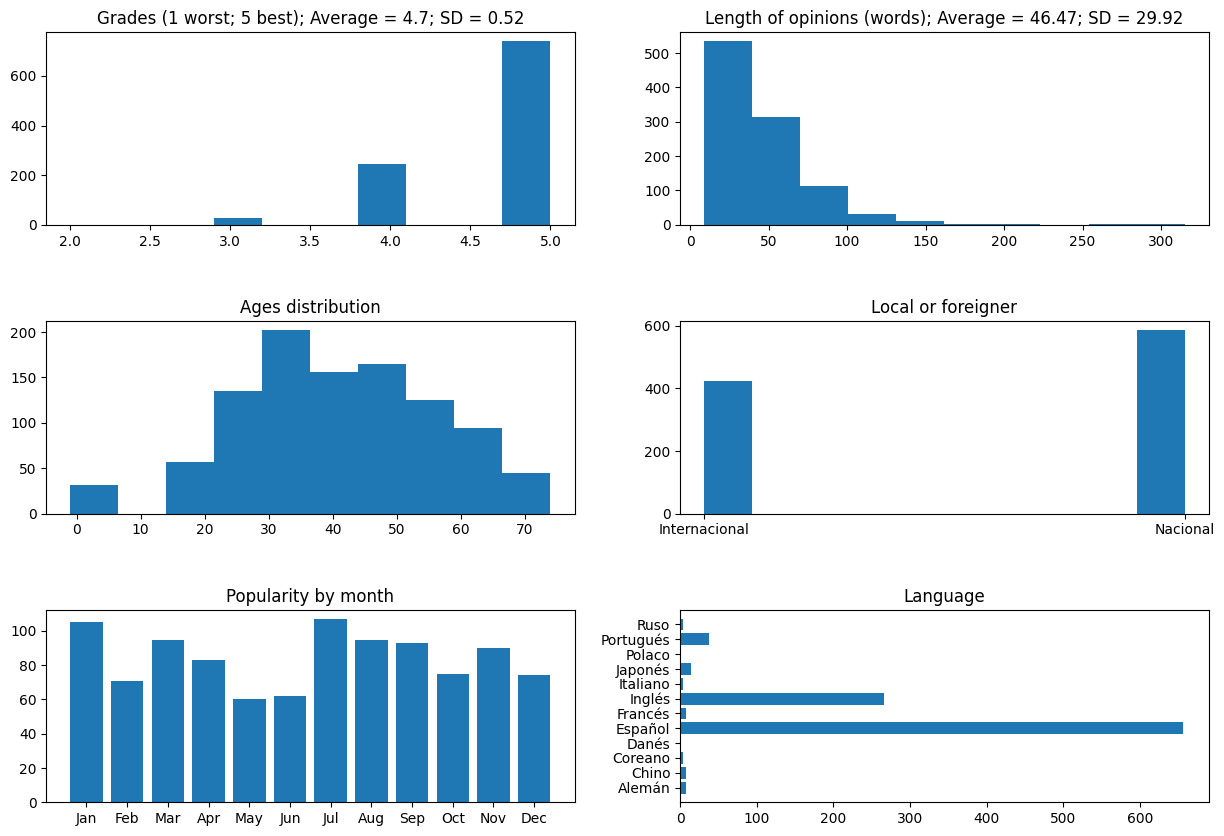

------------------------------ Mercado Hidalgo ------------------------------


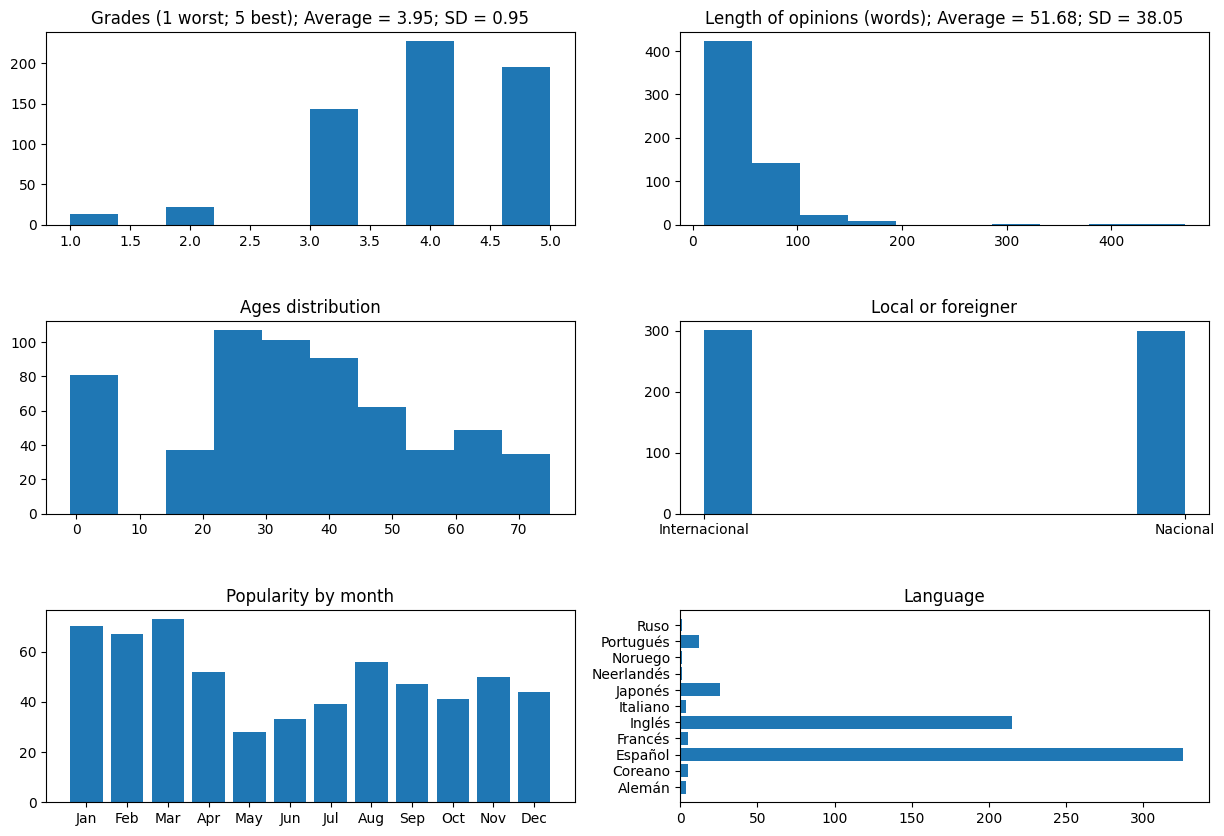

------------------------------ Museo de las Momias ------------------------------


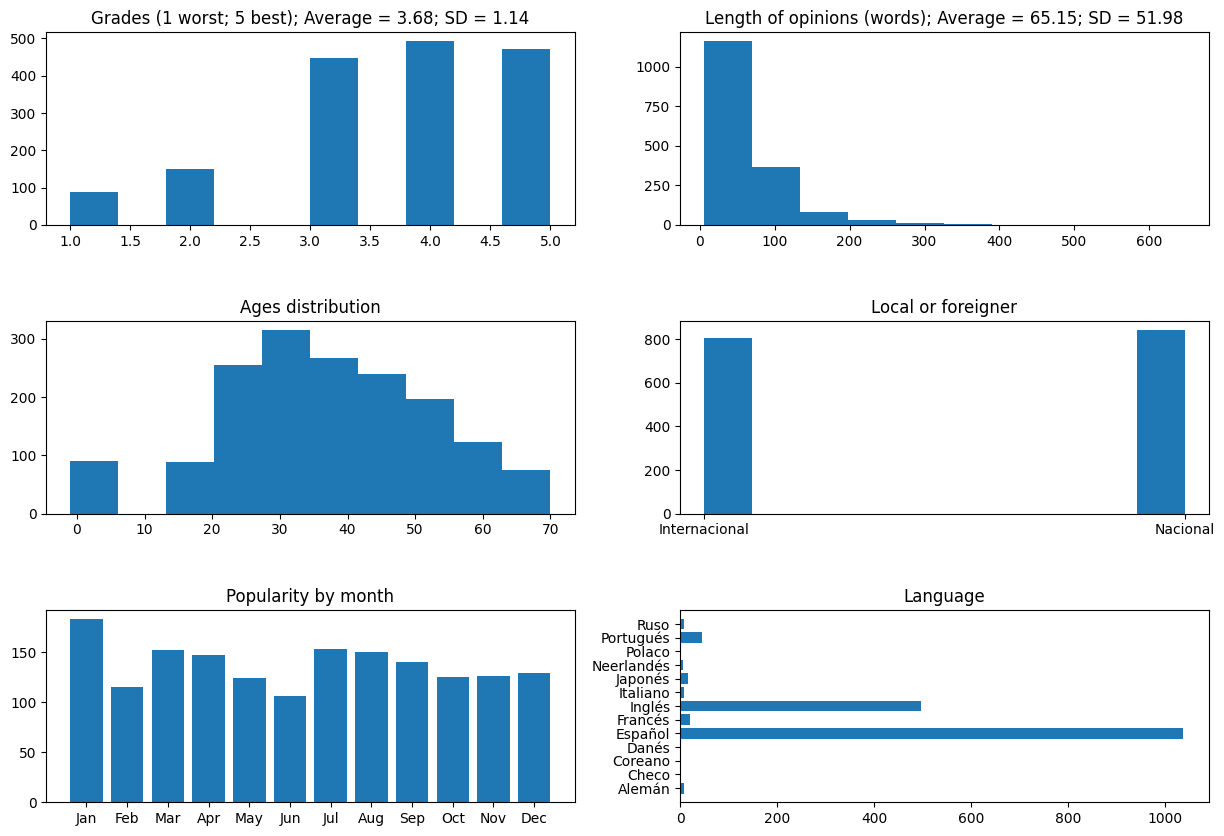

------------------------------ Basilica Colegiata ------------------------------


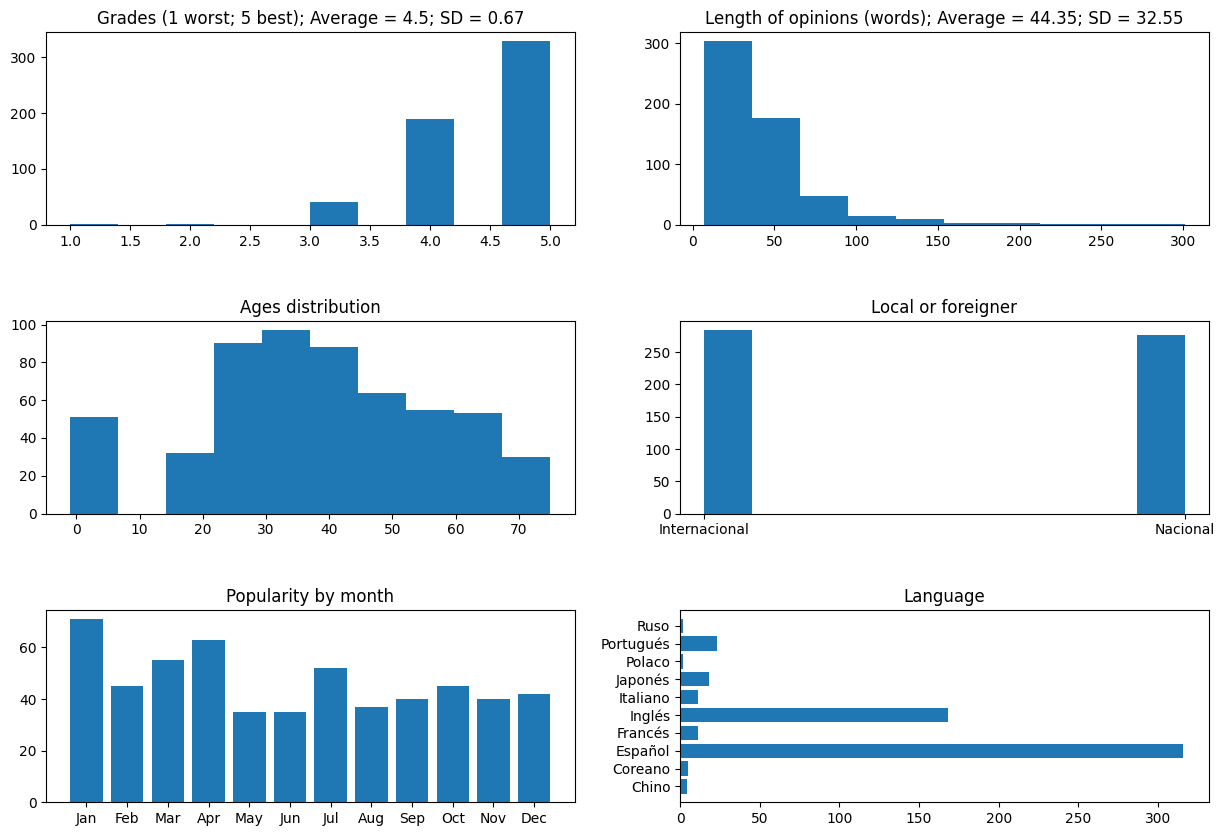

------------------------------ Universidad de Guanajuato ------------------------------


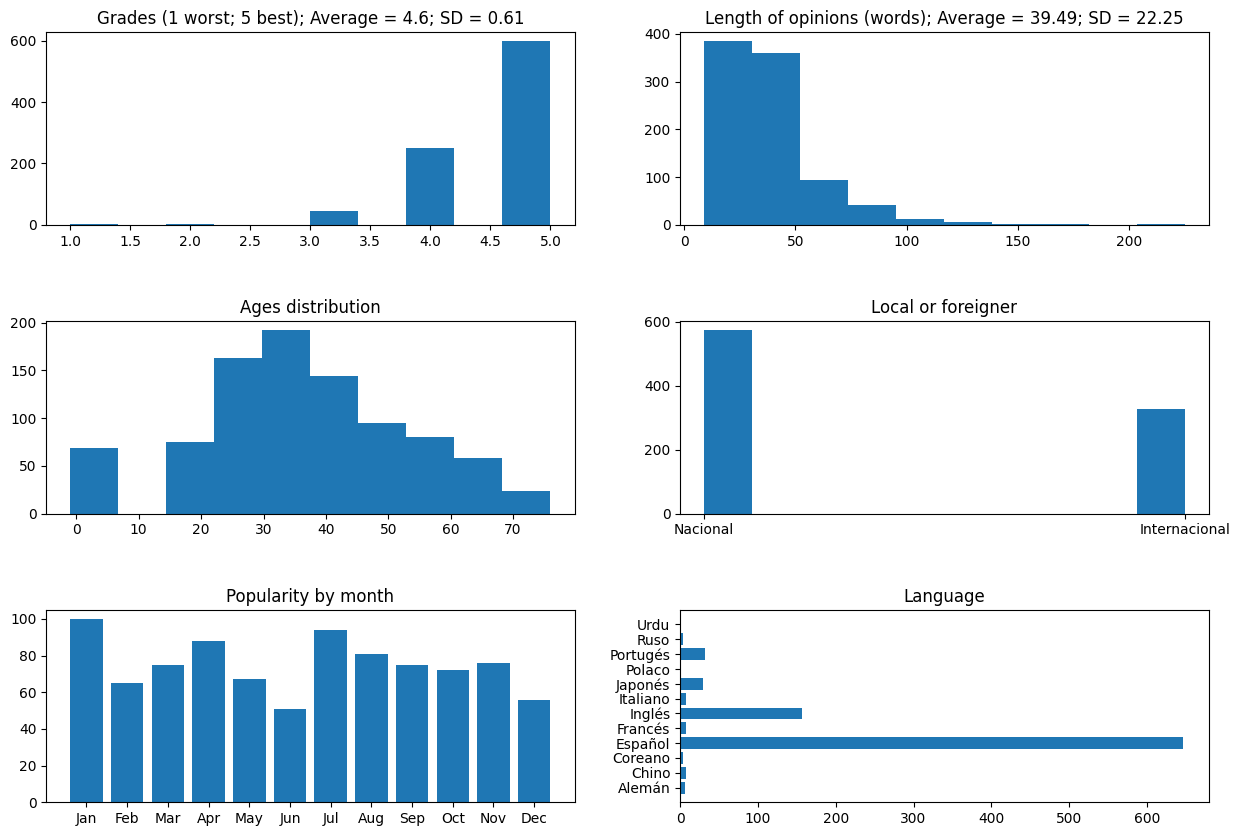

------------------------------ Jardín de la Unión ------------------------------


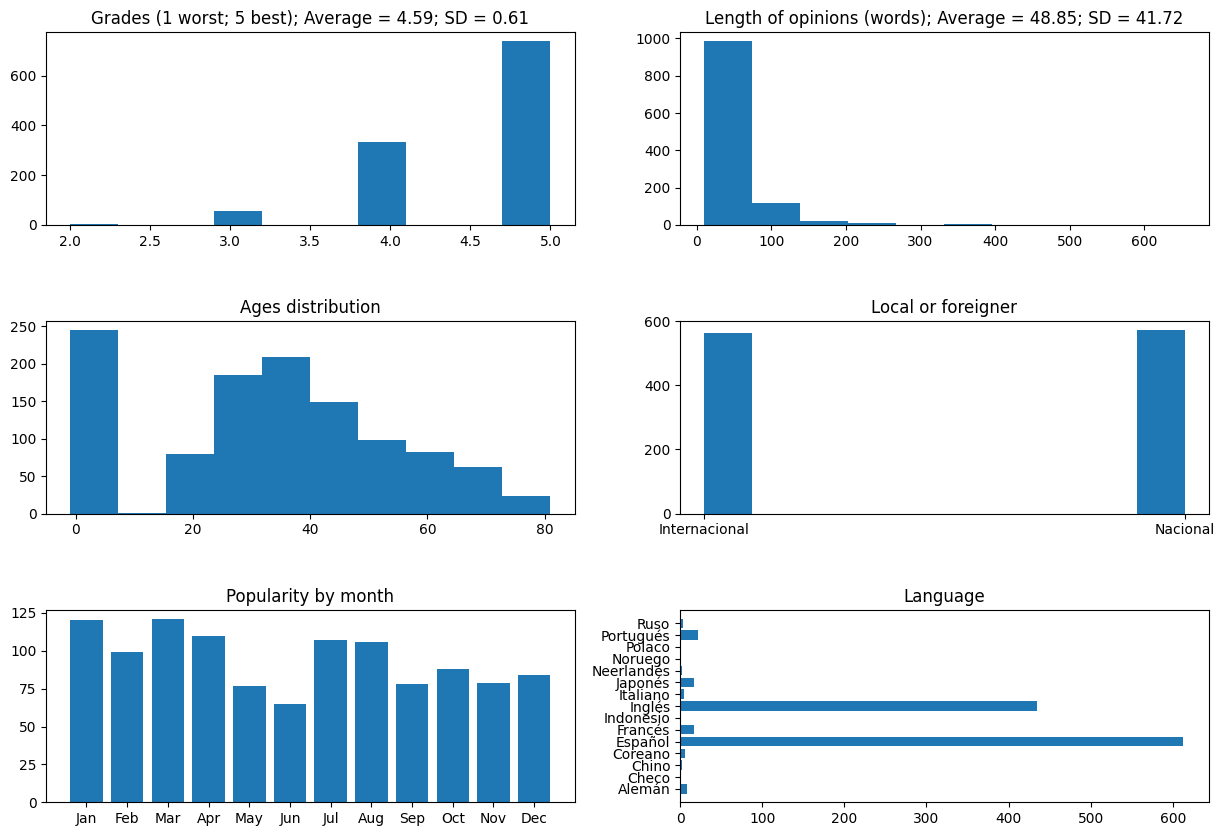

------------------------------ Callejón del Beso ------------------------------


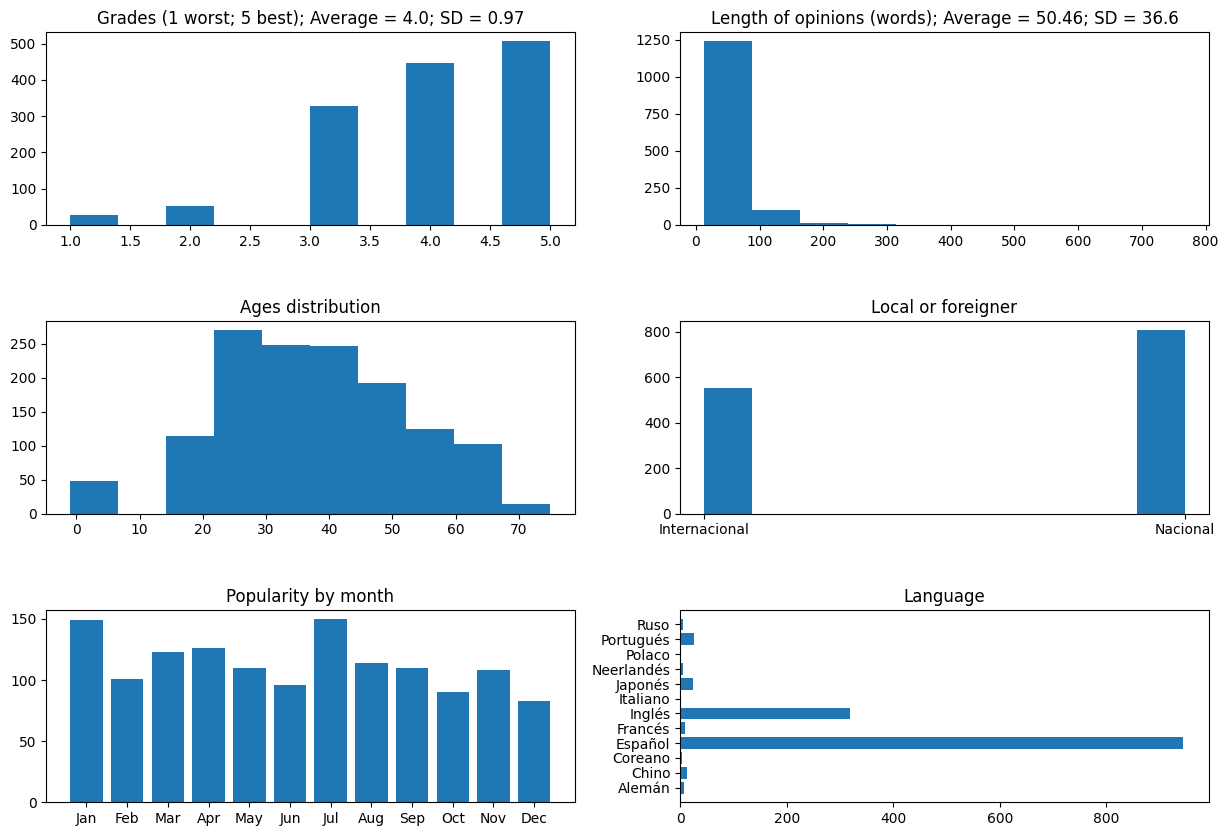

------------------------------ Monumento Pípila ------------------------------


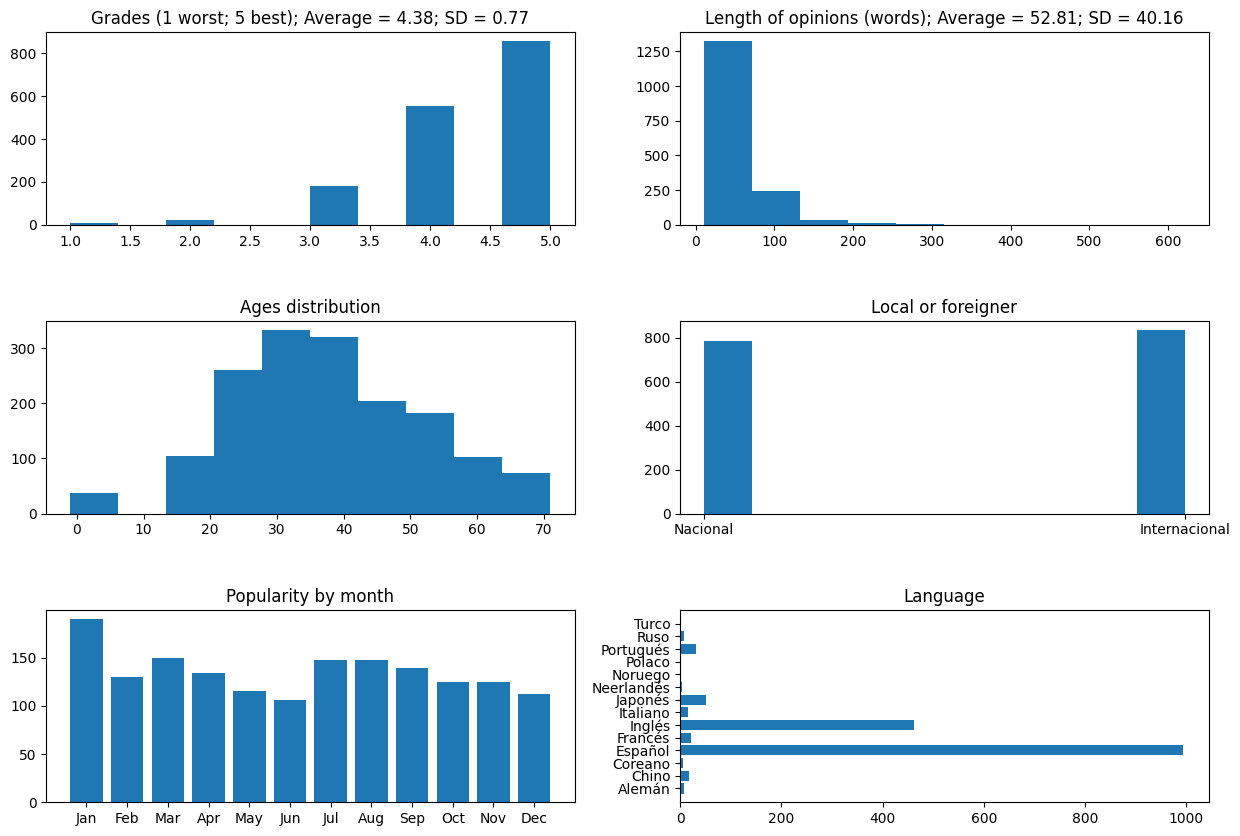

------------------------------ Alhóndiga ------------------------------


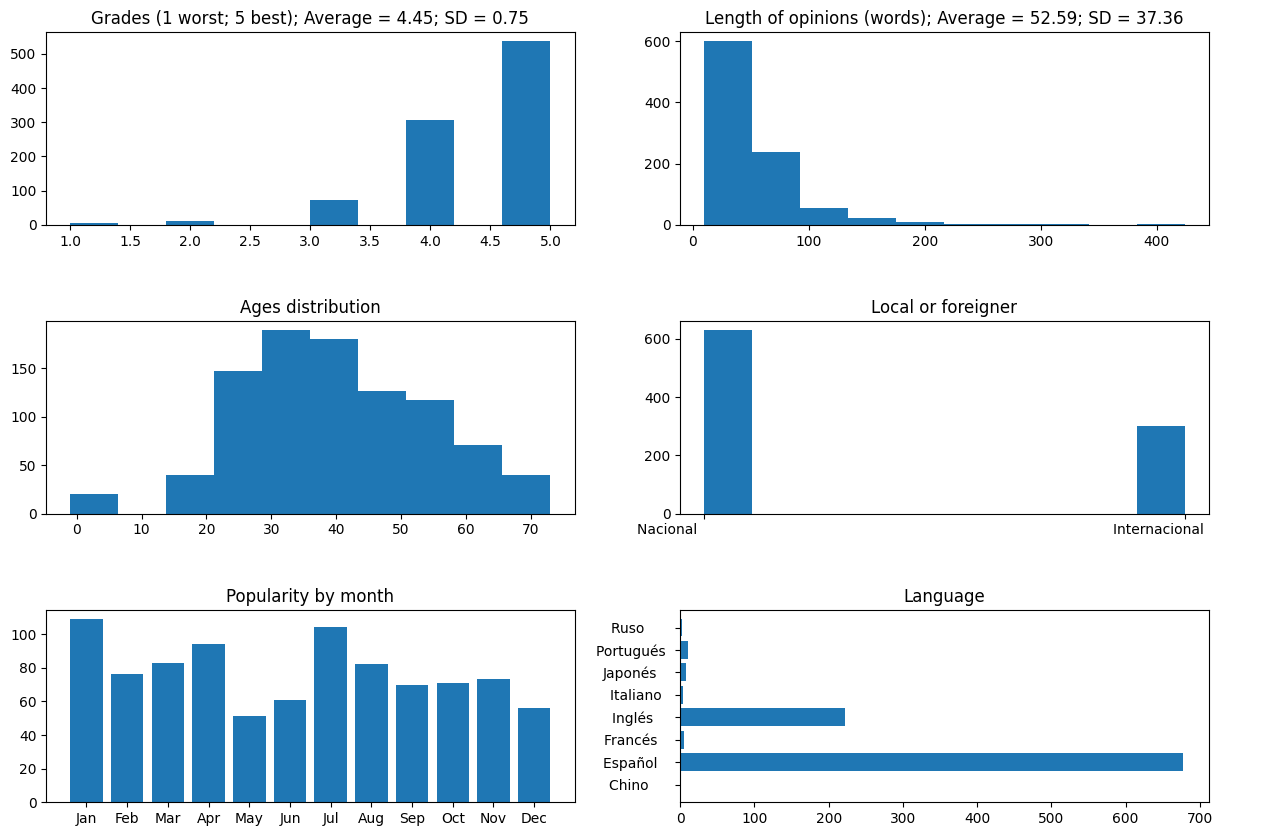

------------------------------ Casa de Diego Rivera ------------------------------


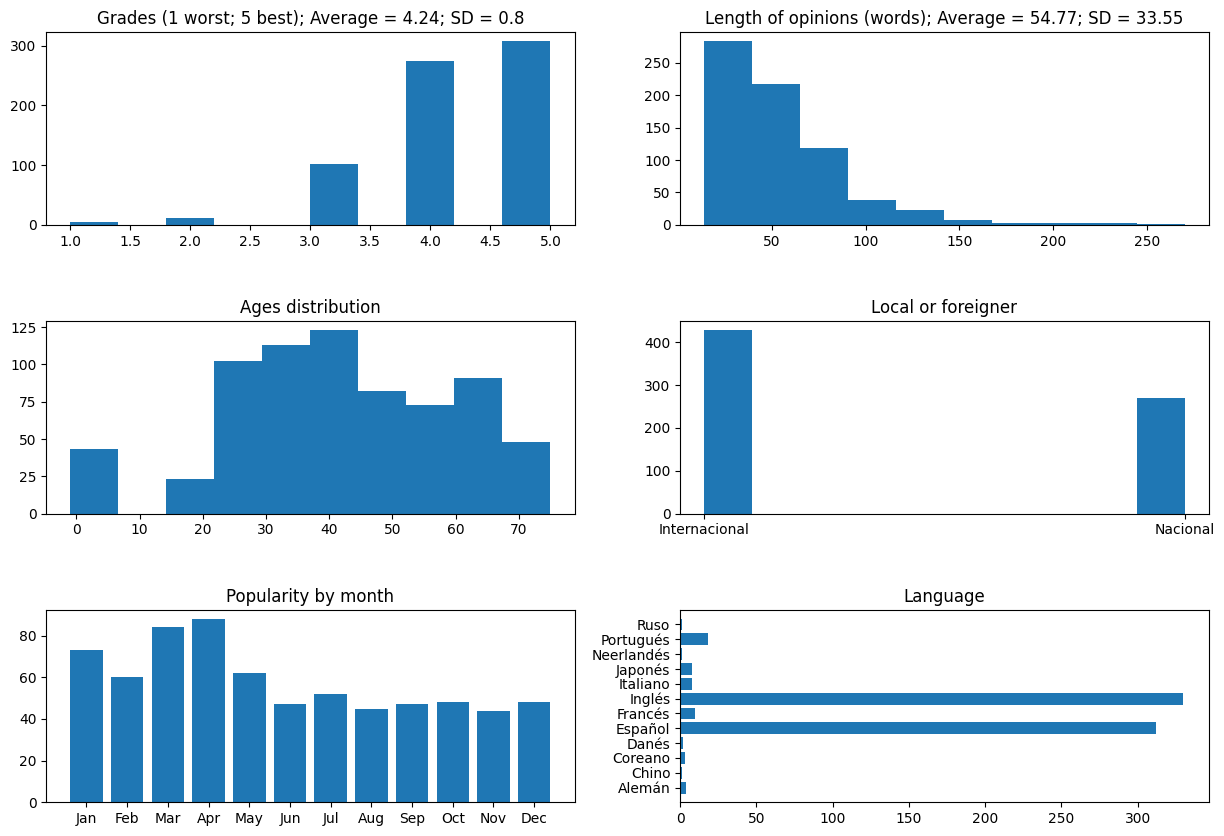

In [141]:
for spot in spots: 
    spot.describe()

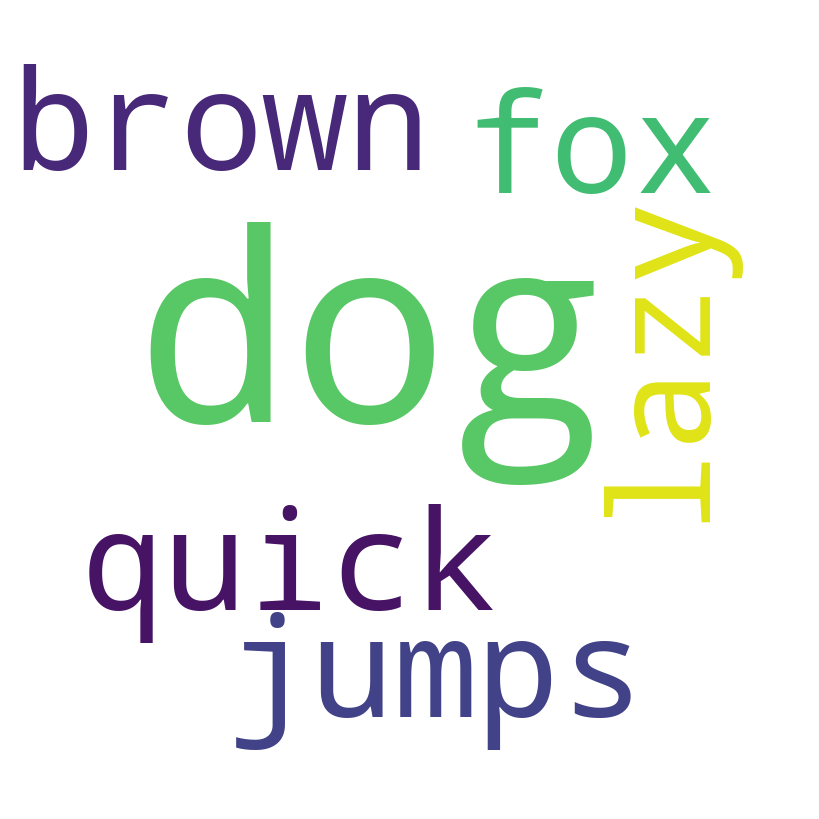

In [146]:
text = "Hola como estas, jajajaja, que haces?"
text = "The quick brown fox jumps over the lazy dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog "

wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=3).generate(text)

plt.figure(figsize=(8,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


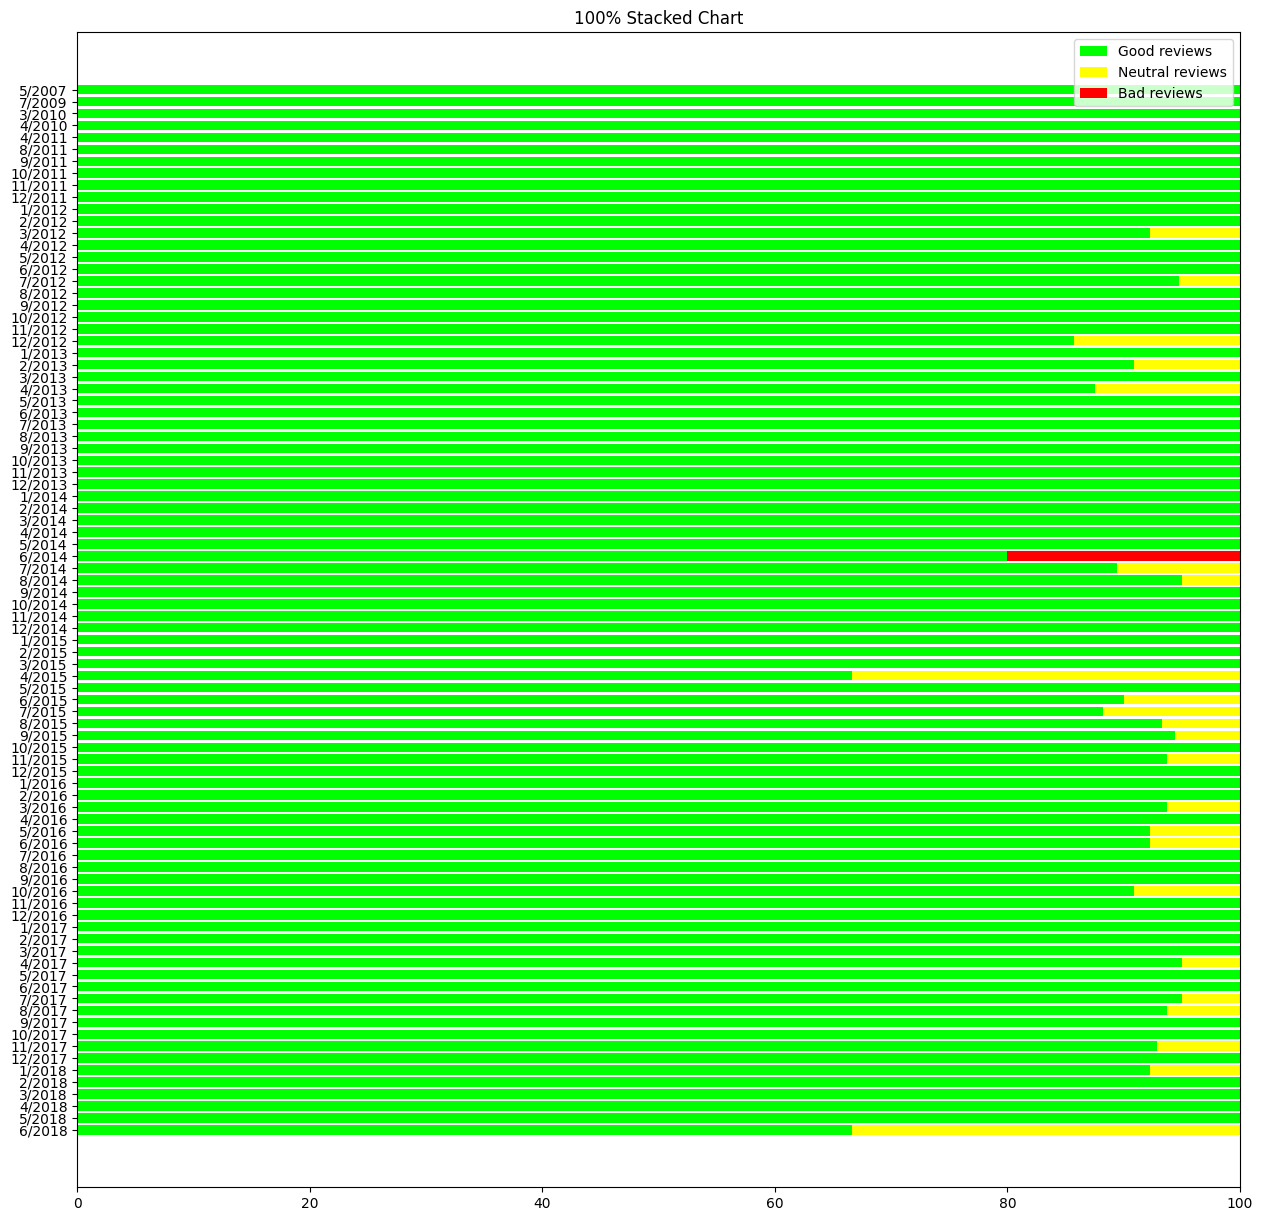

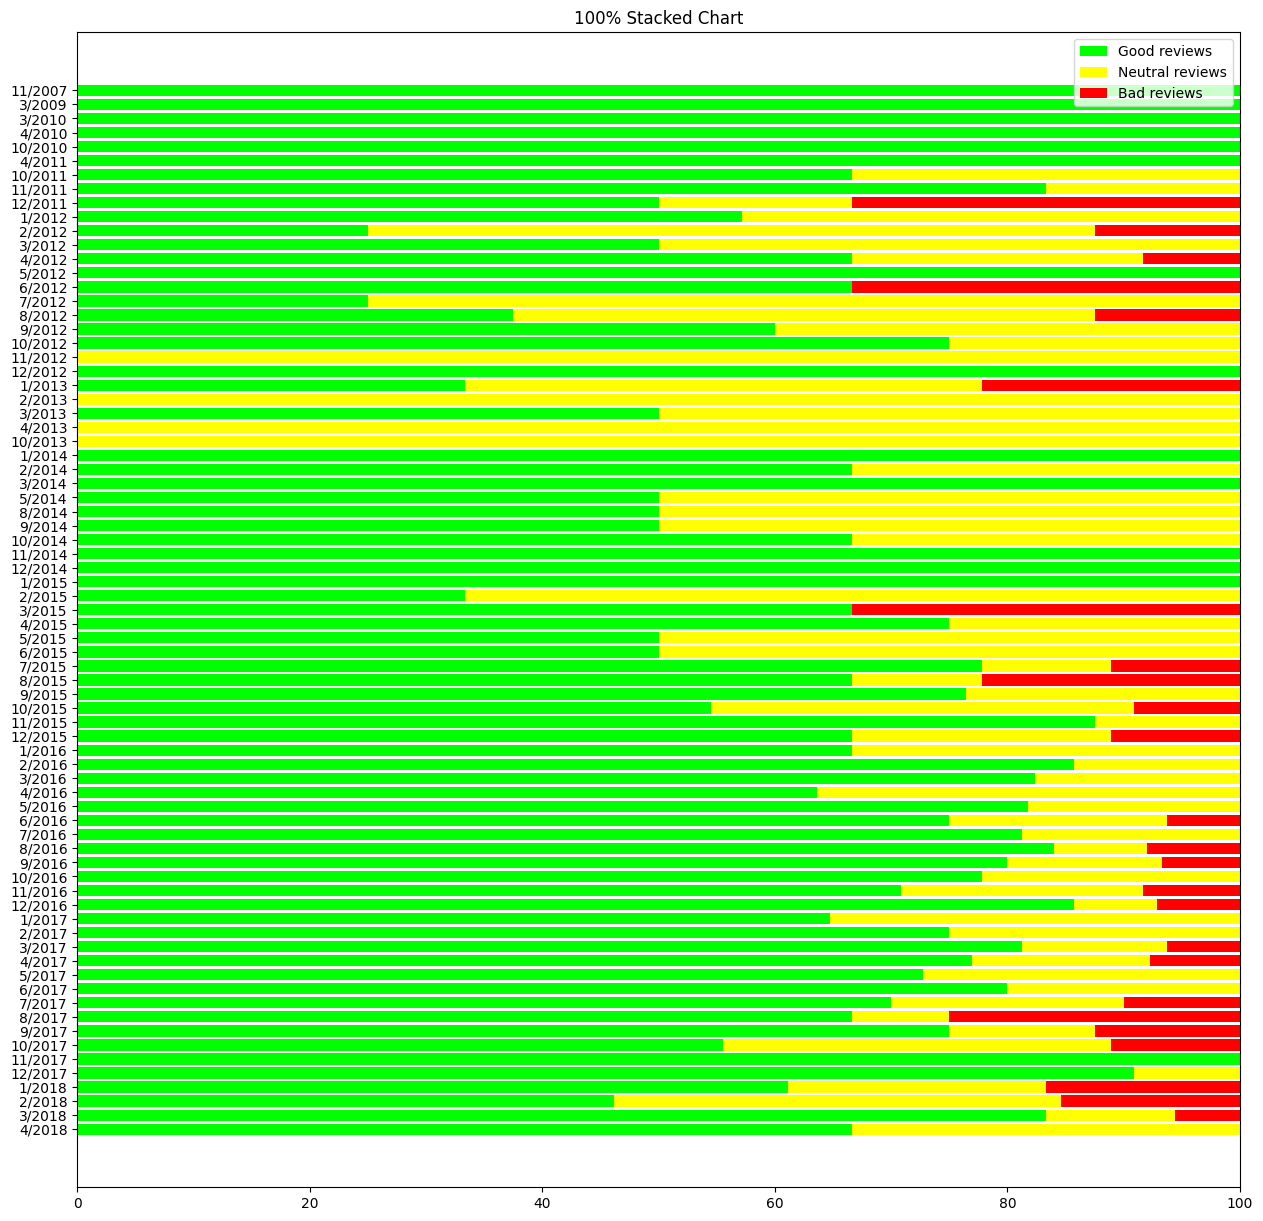

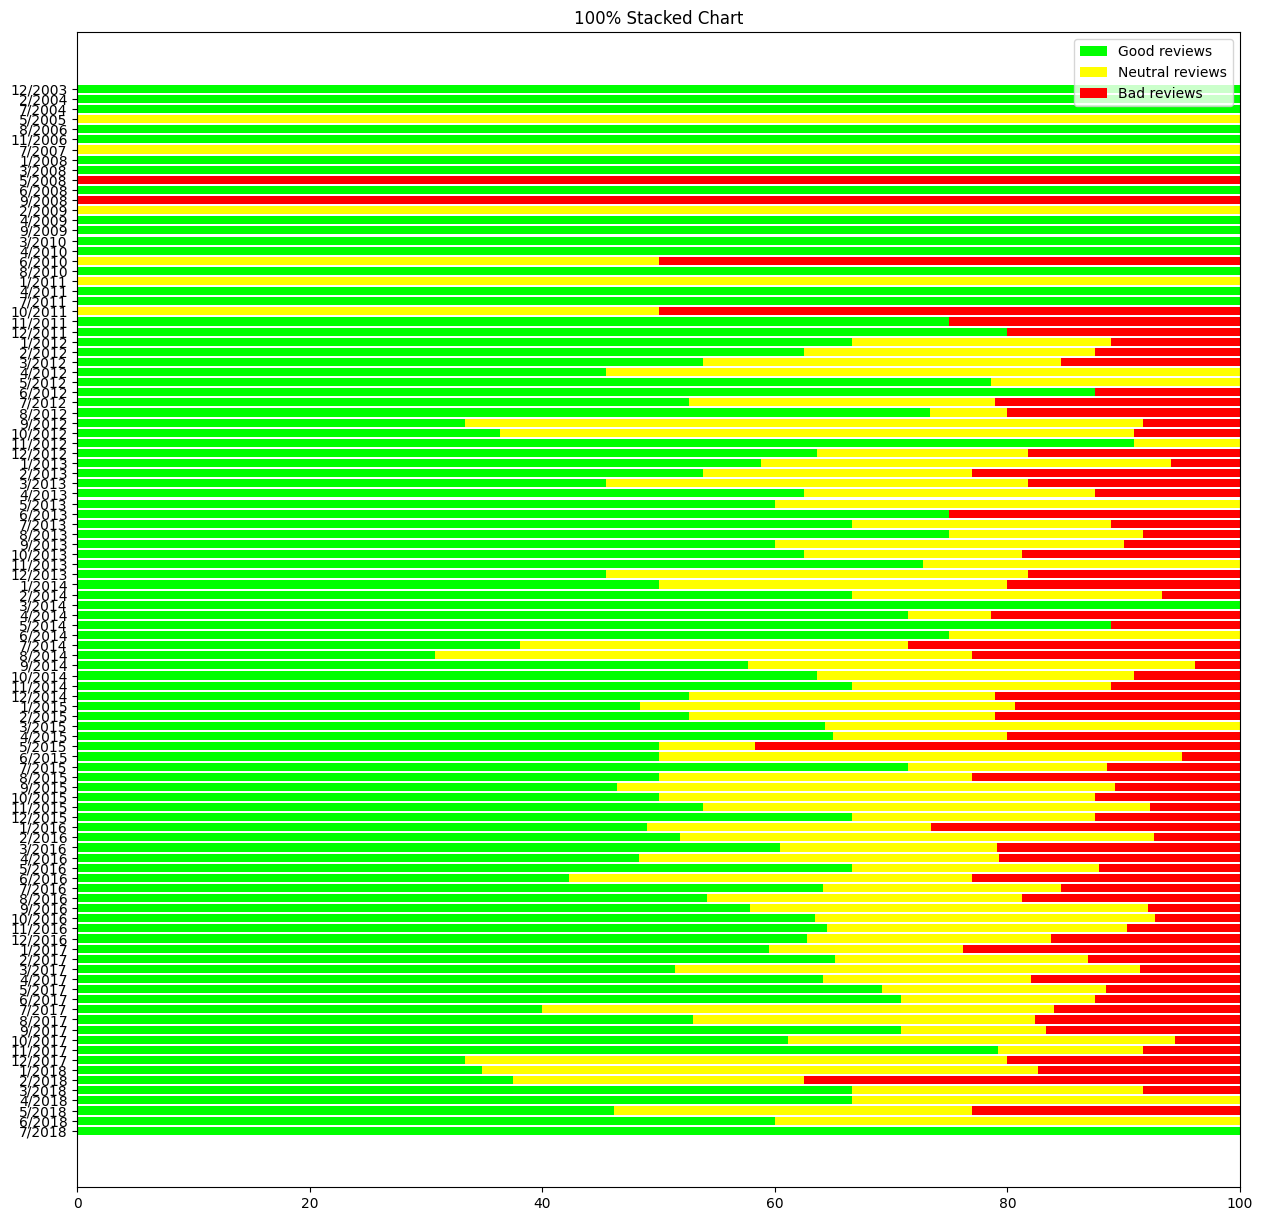

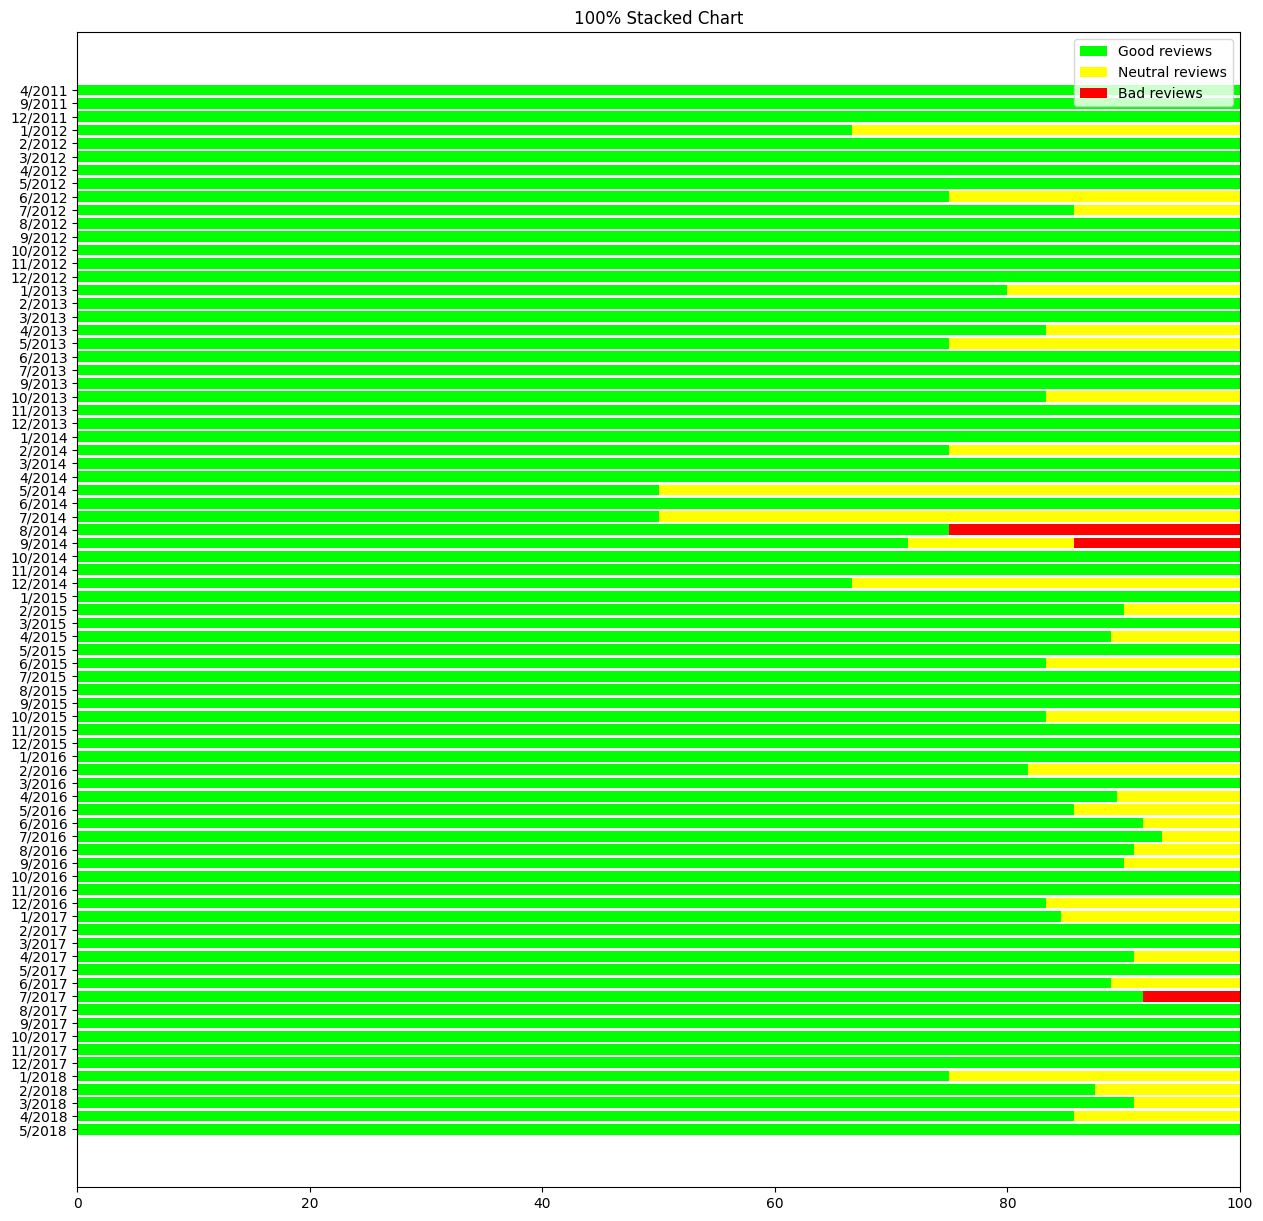

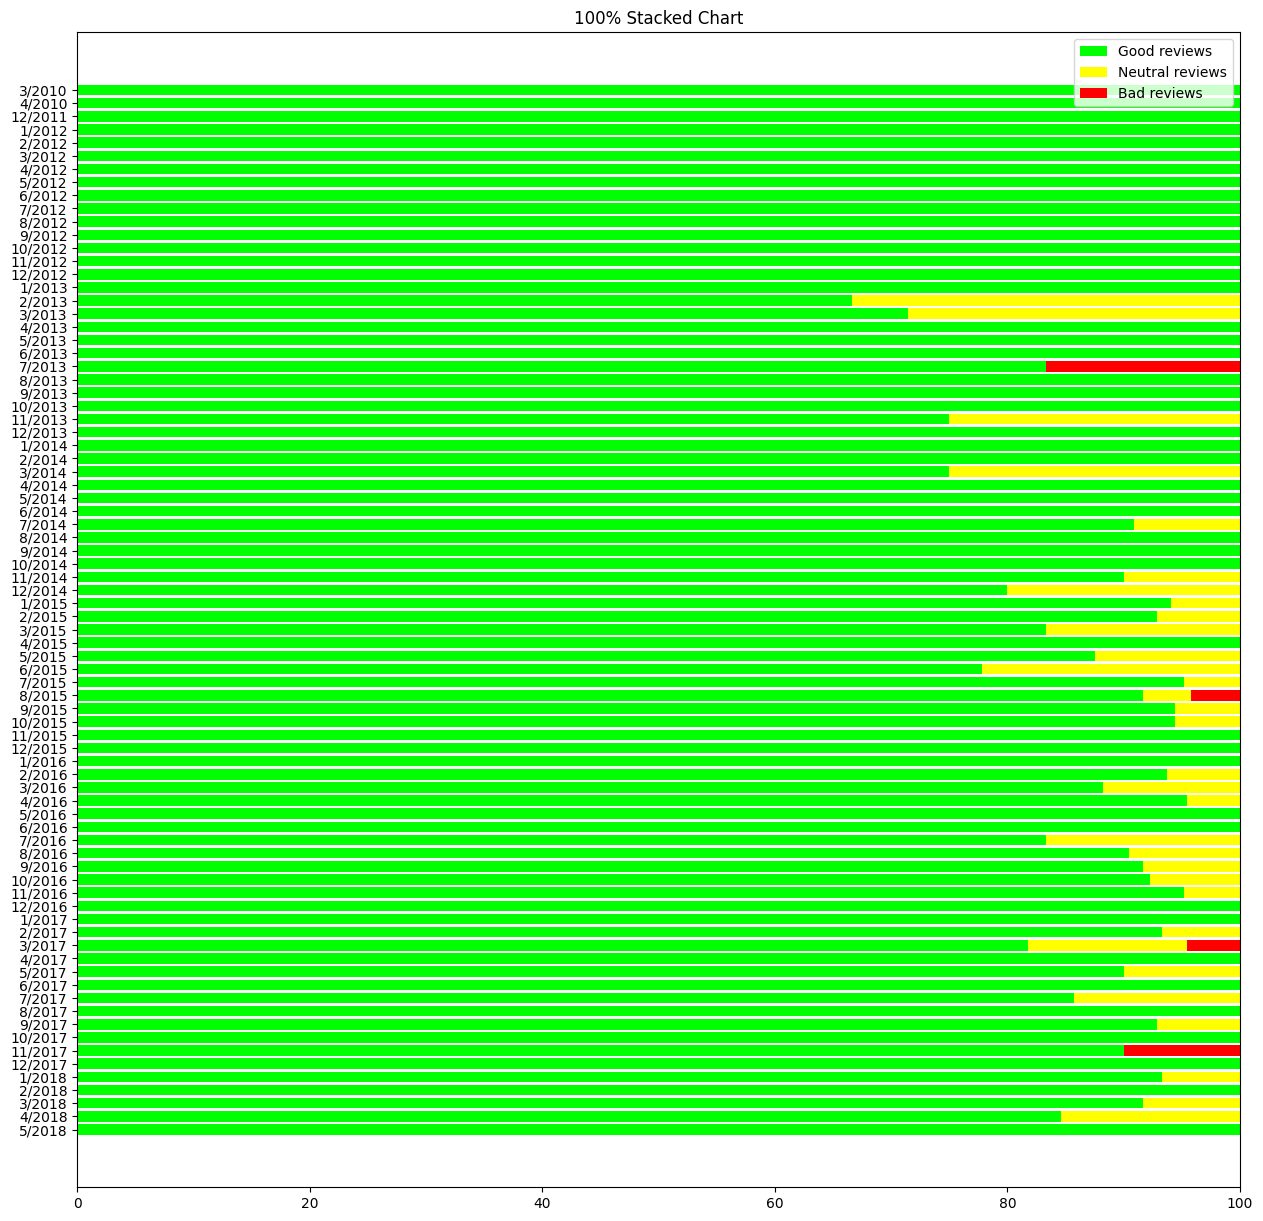

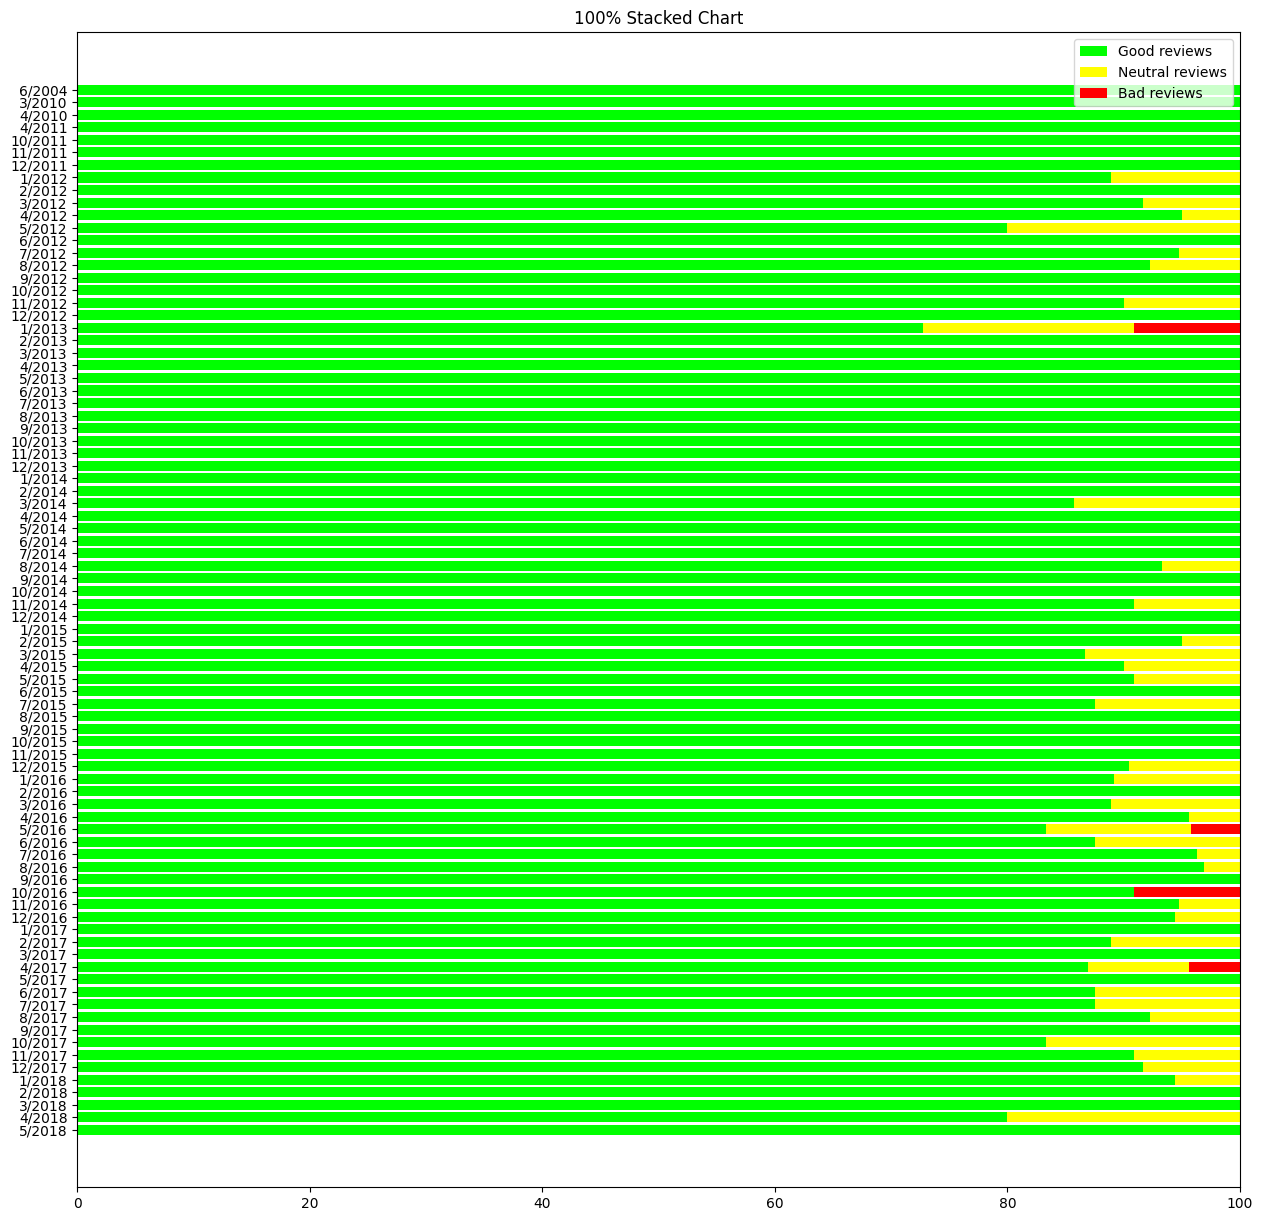

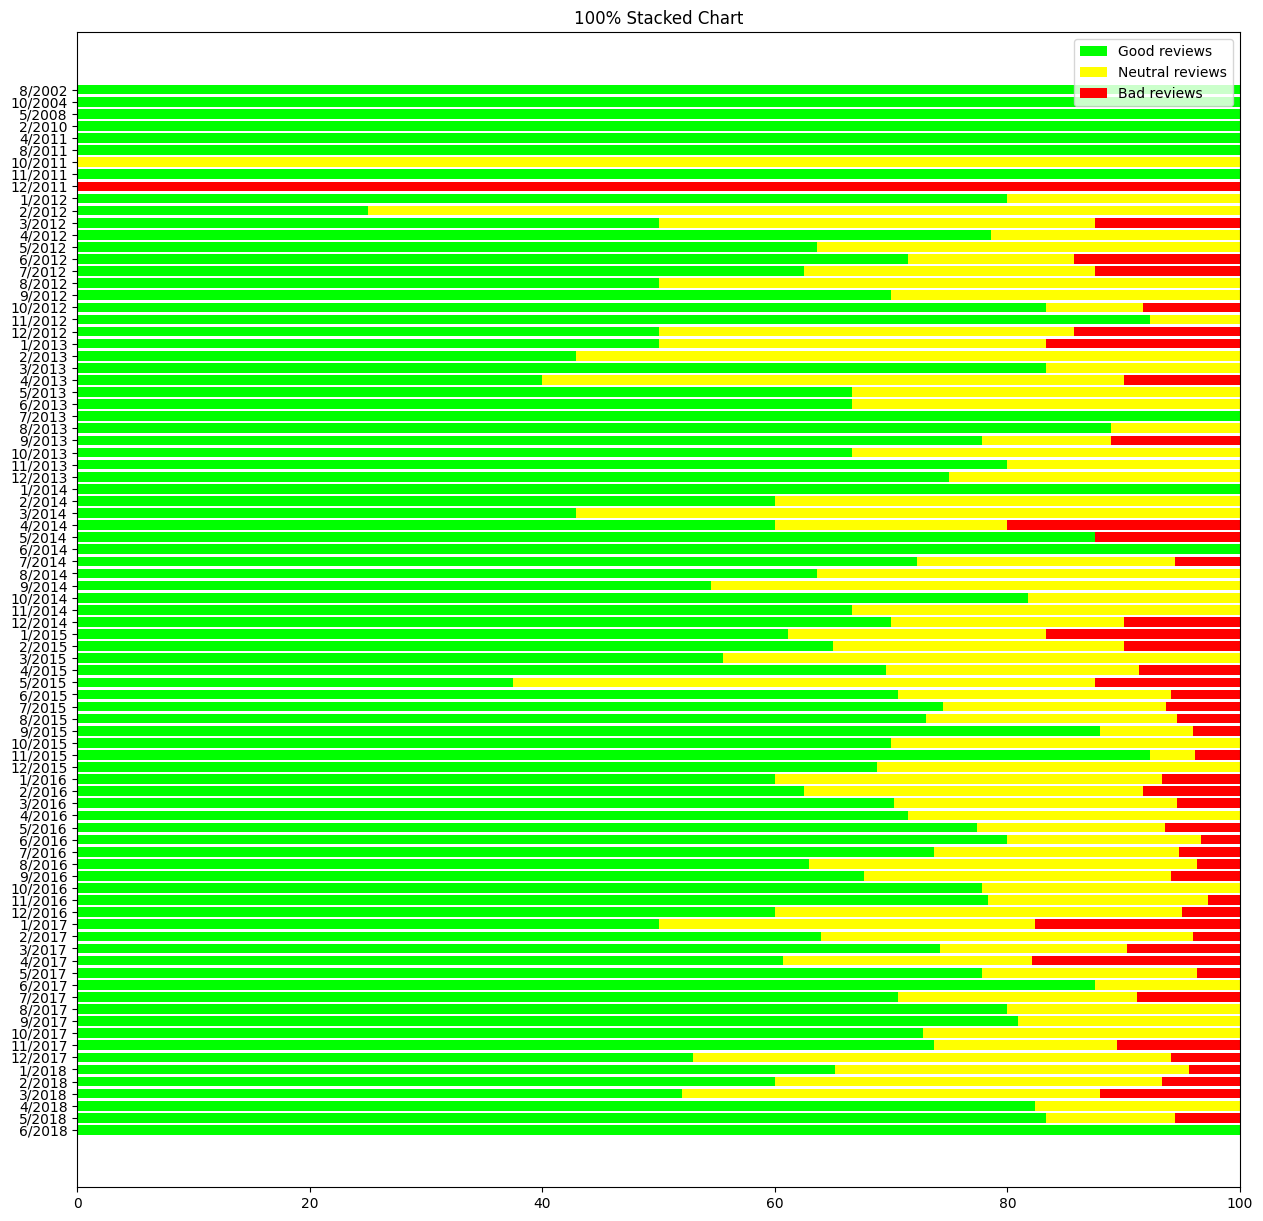

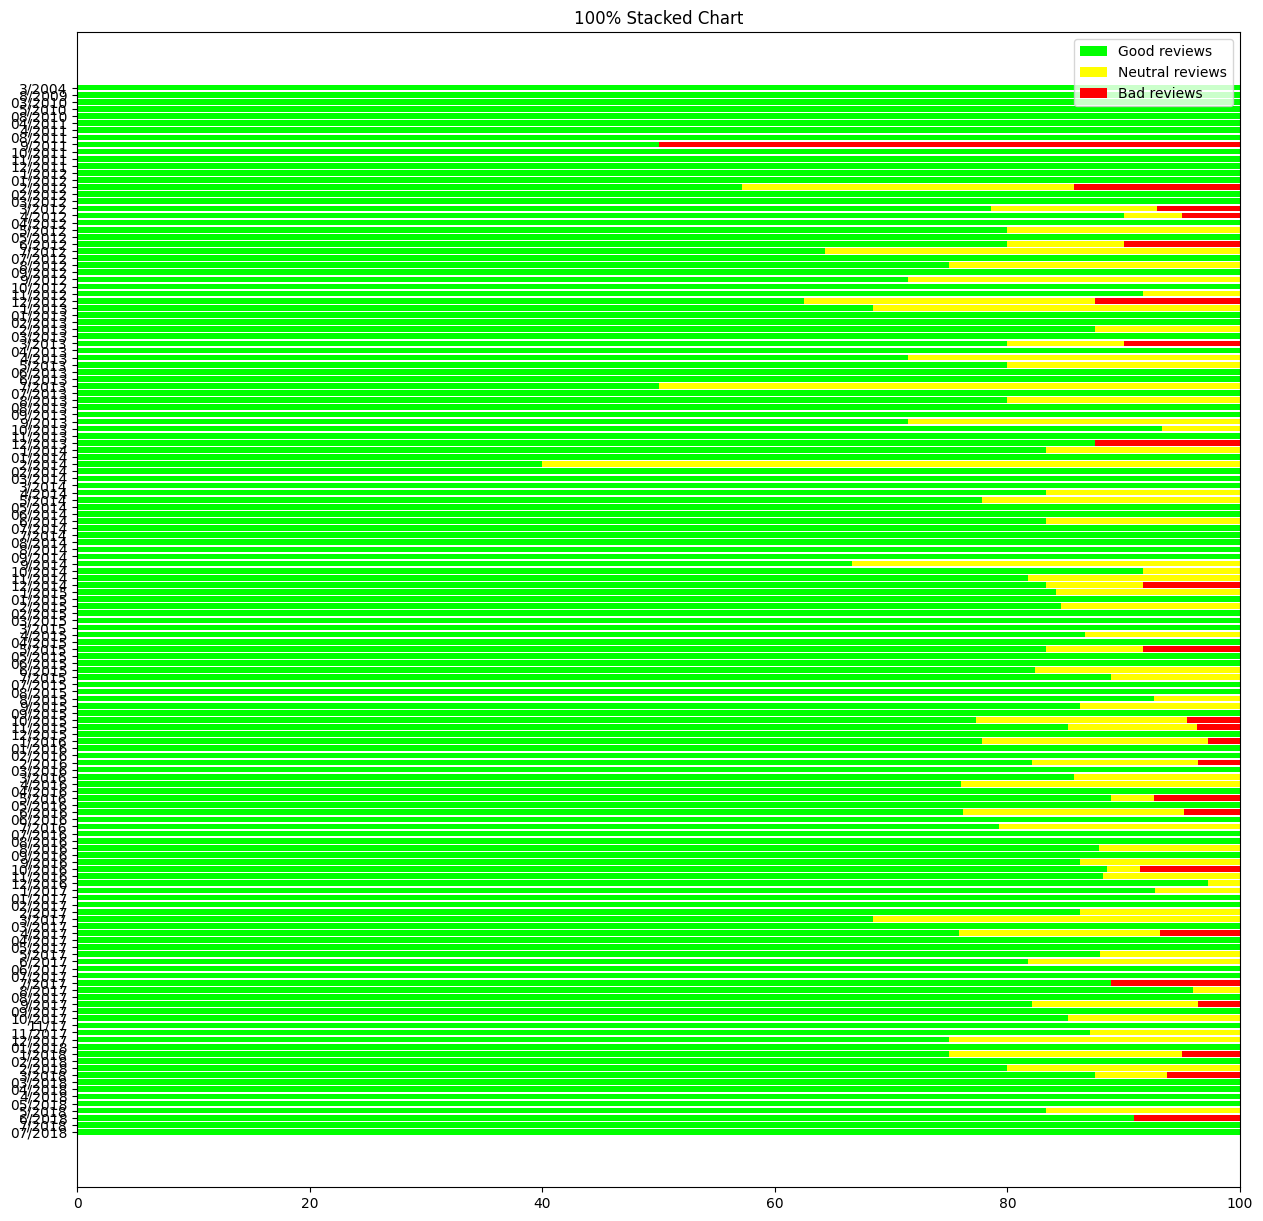

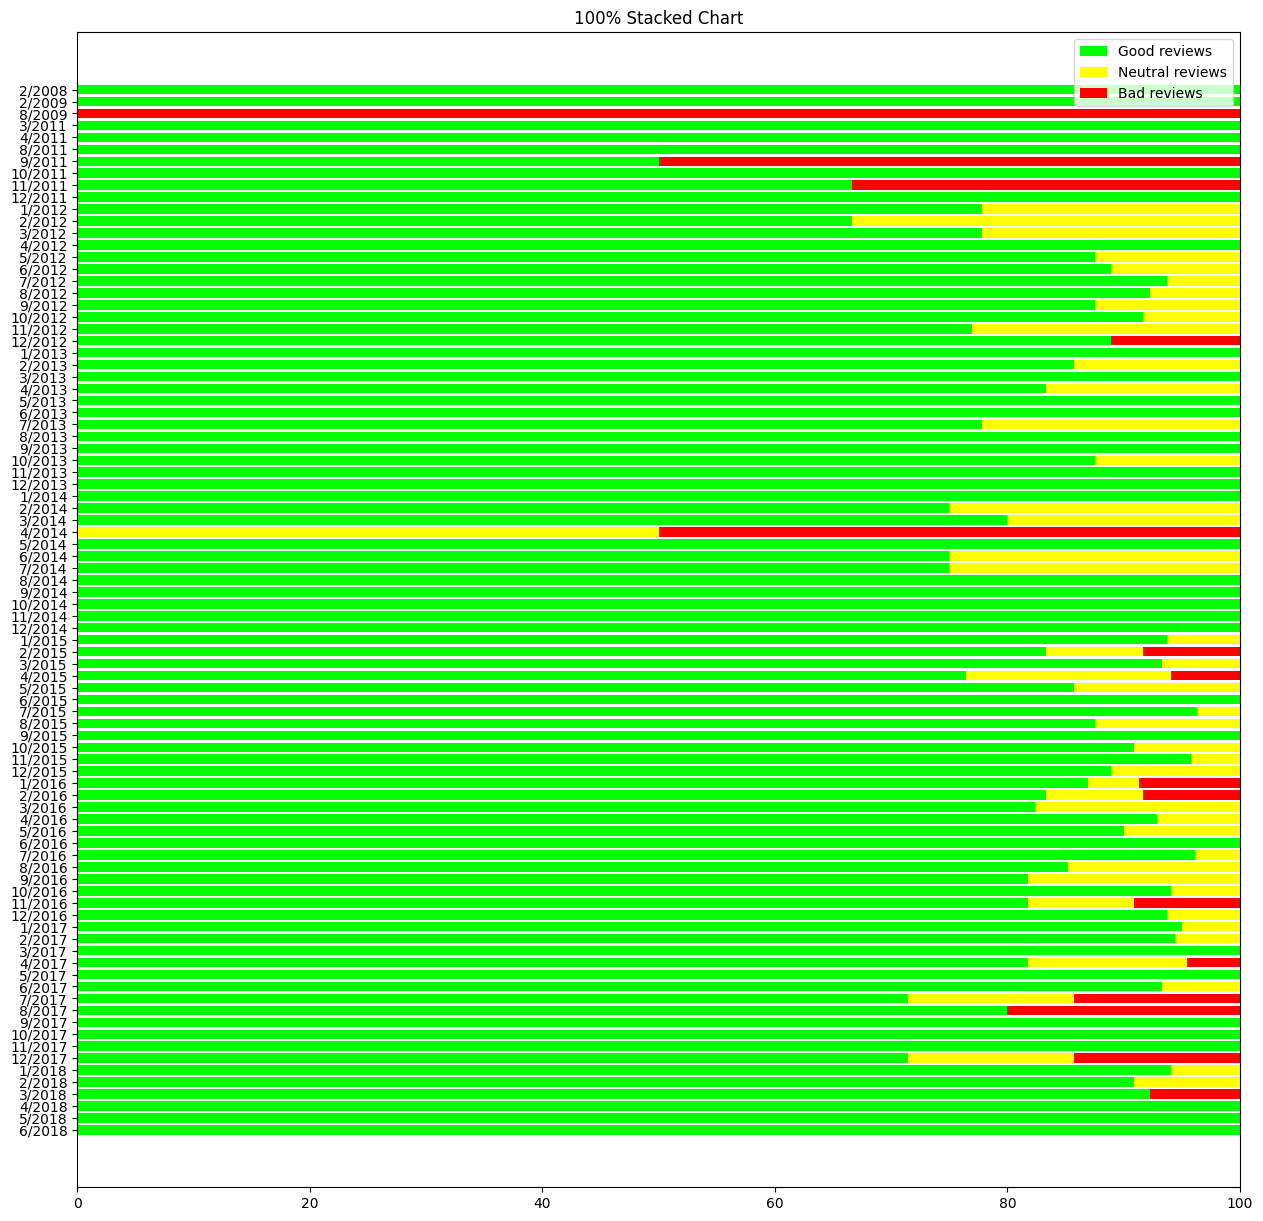

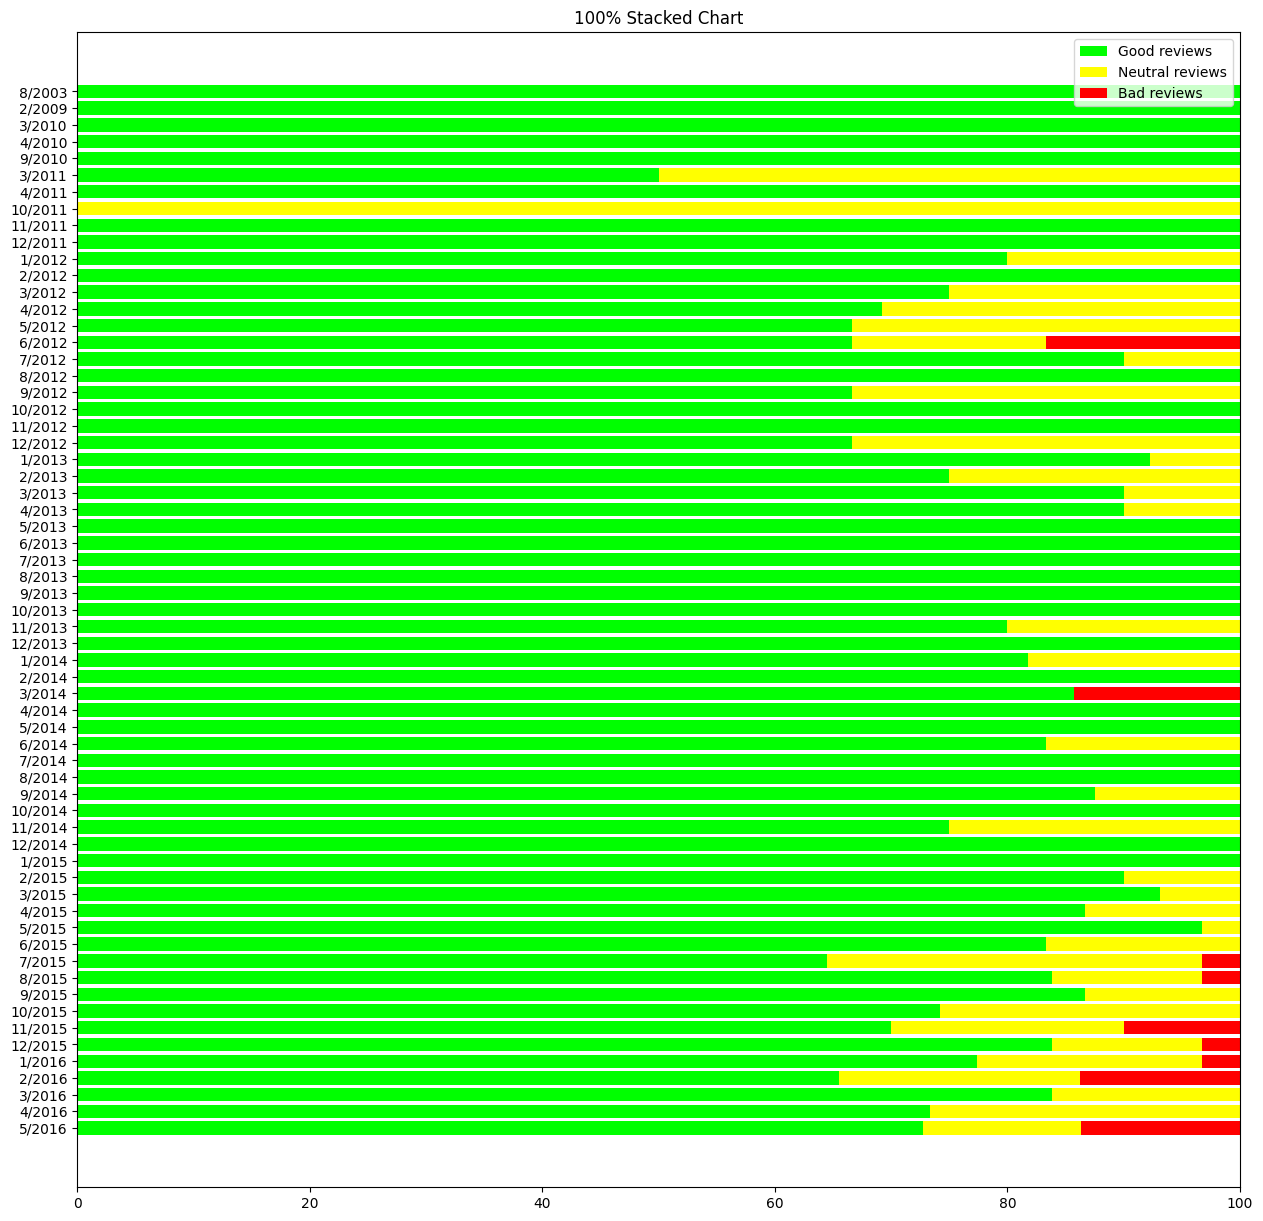

In [145]:
for spot in spots: 
    spot.temporalAnalysis()
    continue
    break